In [57]:
from firm_dynamics.survival_analysis import prepare_df, obtain_survival_fractions, obtain_total_alive_count
from firm_dynamics.hill import hill_hazard, model_survival_curve_hill, neg_log_likelihood_hill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from scipy.integrate import cumulative_trapezoid

In [4]:
df = prepare_df()

In [5]:
df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


In [56]:
def neg_log_likelihood_hill(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill_model_mle(ages, survivors, totals, initial_guess=[0.12, 0.04, 10.0, 5.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K, m]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.15), (0.01, 30), (0.5, 100)]
    constraints = {'type': 'ineq', 'fun': lambda x: x[0] - x[1]}  # mu_ub >= mu_lb
    result = minimize(neg_log_likelihood_hill, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds, constraints=constraints)
    return result


100.0
-732034.6894601469


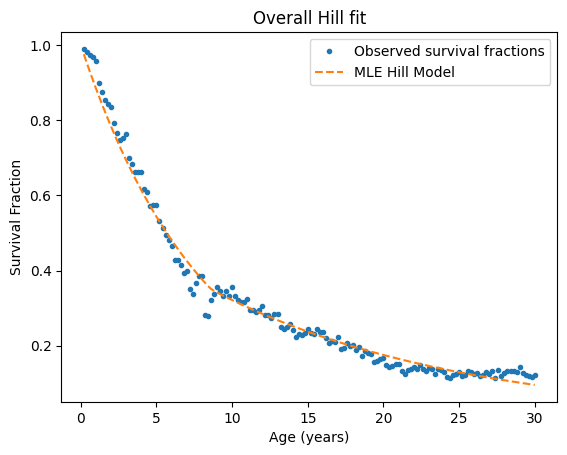

In [58]:
sf, ages = obtain_survival_fractions(df_analysis)

totals, survivors = obtain_total_alive_count(df_analysis)

mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals, [0.13, 0.00001, 10.0, 3.0]).x

print(m)
print(-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

# Plot fit
fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
plt.title(f'Overall Hill fit')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.legend()
plt.show()


G: [0.13772780796801345, 0.06040065635354765, 9.678611031814139, 38.28653412450151]
ll for G: -198294.6508662457


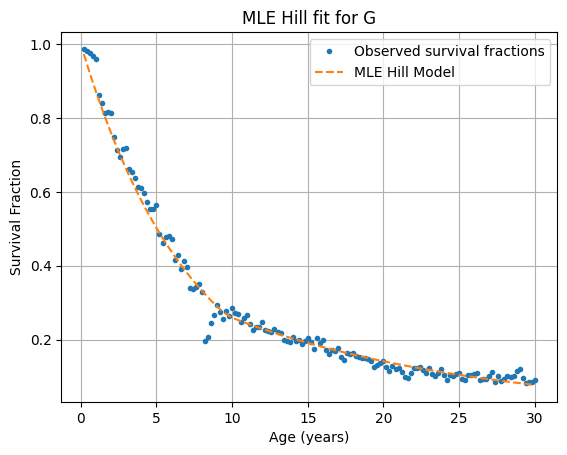

M: [0.10853412588782649, 0.060405453614713986, 10.324137068120953, 20.272105749873536]
ll for M: -106892.4871102542


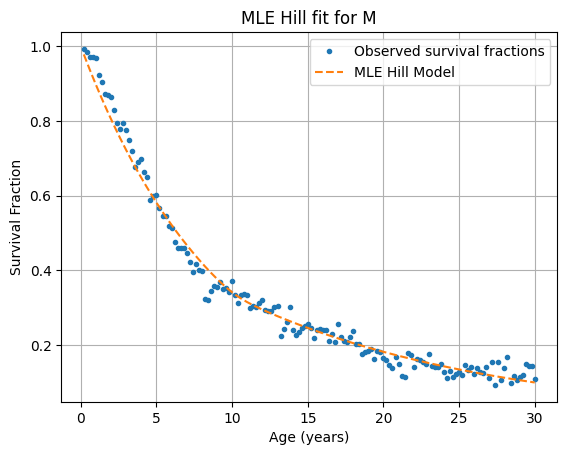

F: [0.08284945935354733, 0.07532165486572806, 7.246079688090822, 99.99992722770091]
ll for F: -47781.663729355525


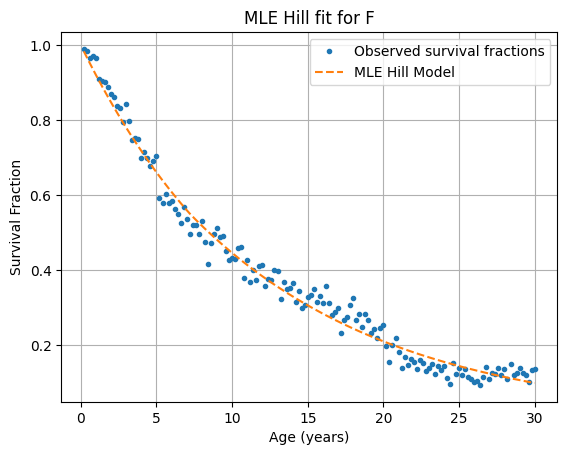

J: [0.13138896943819373, 0.06387240987874851, 9.026894200245238, 64.59003275843841]
ll for J: -56976.63208900678


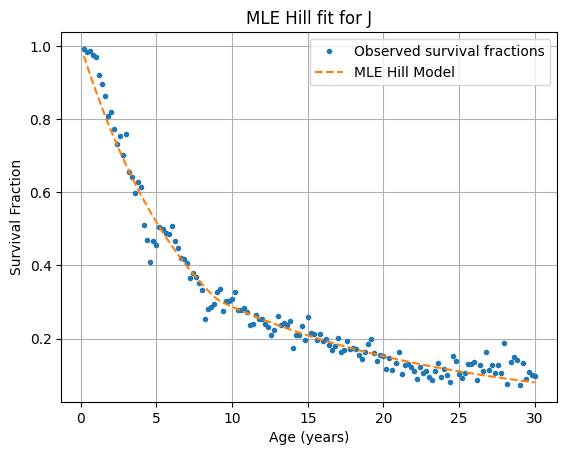

K: [0.07012013735407156, 0.011068176577001085, 17.600965883019793, 11.716328585887581]
ll for K: -56212.87738081392


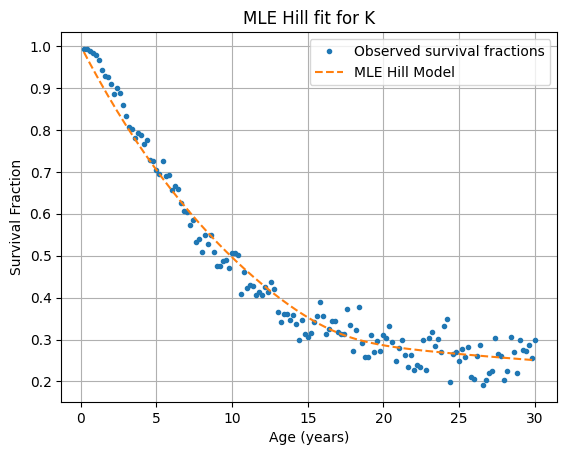

C: [0.09997560159043367, 0.049269924679968866, 8.699286997697827, 100.0]
ll for C: -39535.53797973176


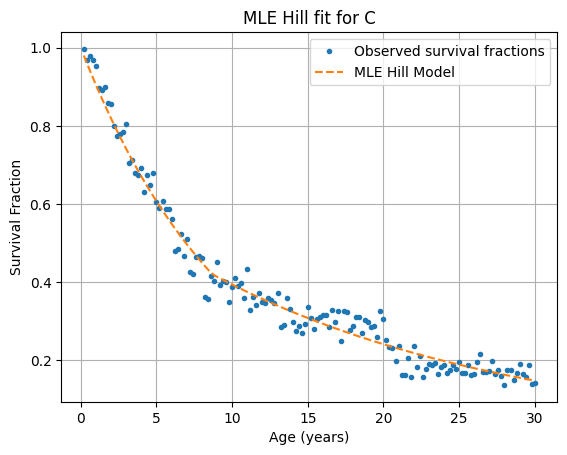

H: [0.19014381450690954, 0.028015942761638372, 6.937678823494837, 100.0]
ll for H: -42974.85049613649


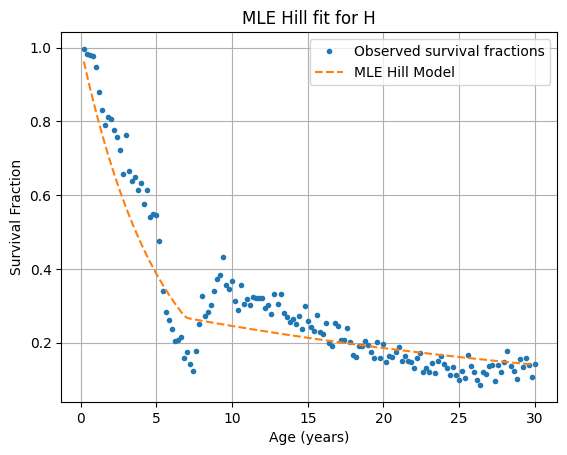

S: [0.14057226596633066, 1e-10, 12.954249620403116, 5.199152676121435]
ll for S: -35752.28673672962


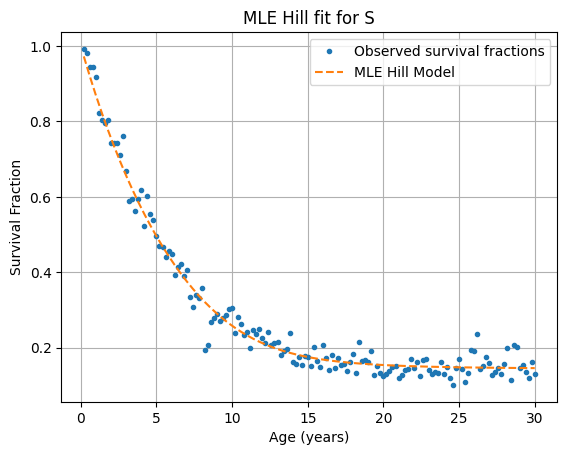

N: [0.12396183075343398, 1e-10, 16.432802053332697, 3.6763982546287552]
ll for N: -37012.32213212014


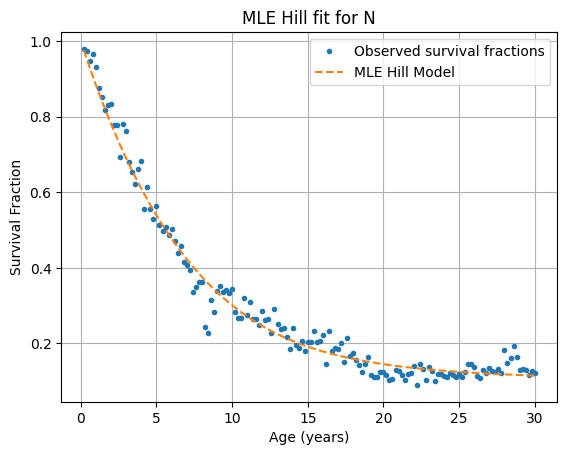

I: [0.12639621277376695, 1.0000001467199392e-10, 20.851484353072767, 3.8694421065642923]
ll for I: -34247.5631736979


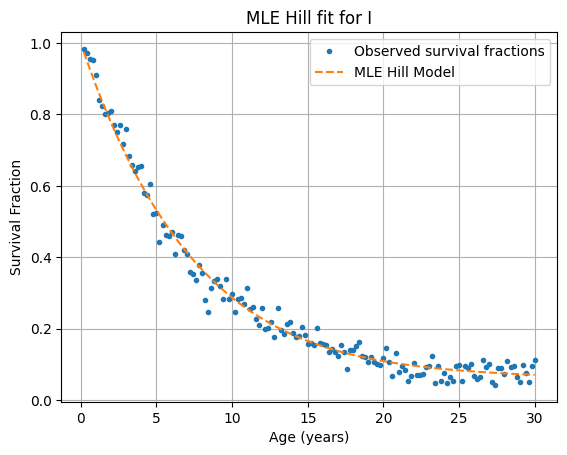

P: [0.12121307544489934, 0.06868412785046317, 9.445279125853938, 100.0]
ll for P: -25155.90457504544


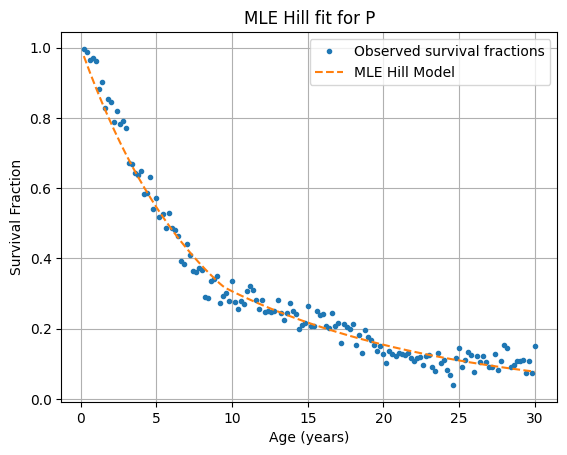

L: [0.07256783090508868, 0.0725678283579821, 14.249169553345428, 0.8209674189944658]
ll for L: -11929.081180359117


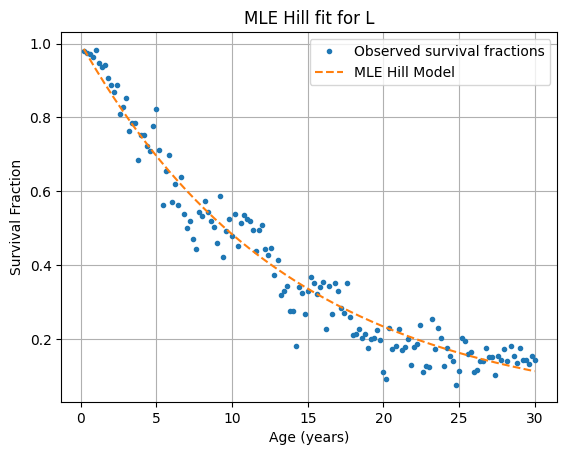

Q: [0.07830172410553711, 0.04719751513515326, 7.792008550188214, 100.0]
ll for Q: -12888.580840419201


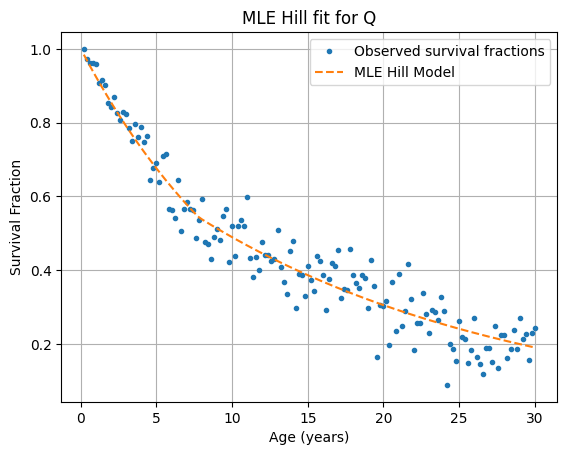

R: [0.13228882837926284, 0.08548611352494333, 8.857641818720507, 100.0]
ll for R: -7519.645951664297


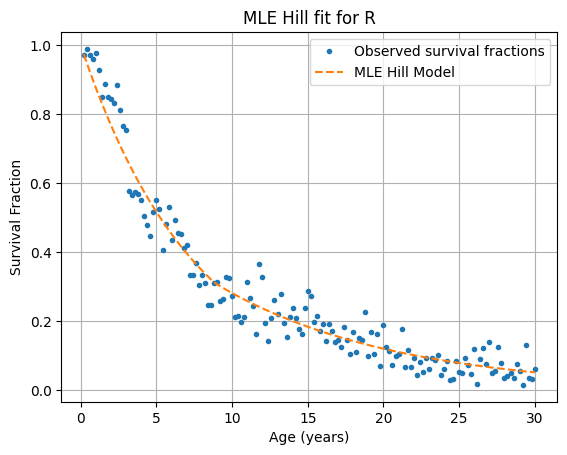

[[0.13772780796801345, 0.06040065635354765, 9.678611031814139, 38.28653412450151], [0.10853412588782649, 0.060405453614713986, 10.324137068120953, 20.272105749873536], [0.08284945935354733, 0.07532165486572806, 7.246079688090822, 99.99992722770091], [0.13138896943819373, 0.06387240987874851, 9.026894200245238, 64.59003275843841], [0.07012013735407156, 0.011068176577001085, 17.600965883019793, 11.716328585887581], [0.09997560159043367, 0.049269924679968866, 8.699286997697827, 100.0], [0.19014381450690954, 0.028015942761638372, 6.937678823494837, 100.0], [0.14057226596633066, 1e-10, 12.954249620403116, 5.199152676121435], [0.12396183075343398, 1e-10, 16.432802053332697, 3.6763982546287552], [0.12639621277376695, 1.0000001467199392e-10, 20.851484353072767, 3.8694421065642923], [0.12121307544489934, 0.06868412785046317, 9.445279125853938, 100.0], [0.07256783090508868, 0.0725678283579821, 14.249169553345428, 0.8209674189944658], [0.07830172410553711, 0.04719751513515326, 7.792008550188214, 

In [64]:
sector_ll_hill = []
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = []
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    result1 = fit_hill_model_mle(ages, survivors, totals, [0.124, 0.04, 10, 5])
    result2 = fit_hill_model_mle(ages, survivors, totals, [0.2, 0.03, 7, 50])

    result = result1 if result1.fun < result2.fun else result2
    mu_ub, mu_lb, K, m = result.x
    print(f'{fil}: {[float(x) for x in result.x]}')

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    sector_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))
    parameters.append([float(x) for x in result.x])

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()
print(parameters)

$f(a) = (1+\alpha t) ^{-\lambda / \alpha}$  
$\mu(s) = \frac{\lambda}{1+\alpha s}$

In [13]:
# ---- Closed-form survival function ----
def power_survival_function(t, lam, alpha):
    return (1 + alpha * t) ** (-lam / alpha)

# ---- Predict survival over a list of ages ----
def model_survival_curve_power(ages, lam, alpha):
    return np.array([power_survival_function(t, lam, alpha) for t in ages])

# ---- Least squares objective function ----
def objective_power(params, ages, observed_survival):
    lam, alpha = params
    if lam <= 0 or alpha < 0:
        return np.inf  # invalid parameters
    predicted = model_survival_curve_power(ages, lam, alpha)
    return np.sum((predicted - observed_survival) ** 2)

# ---- Fit the model using least squares ----
def fit_power_model(ages, survival_fractions):
    initial_guess = [0.2, 0.1]  # lambda, alpha
    bounds = [(1e-5, None), (0, None)]
    result = minimize(objective_power, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# - ages: list or array of firm ages
# - survival_fractions: corresponding empirical survival fractions

# # Create age bins (e.g., every 2 years)
# bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
# df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)
# # Compute survival fraction per bin
# survival_fractions, ages = obtain_survival_fractions(df_analysis)

# result = fit_power_model(ages, survival_fractions)
# lam_fit, alpha_fit = result.x

# # Plot result
# ages_sorted = np.linspace(0, max(ages), 100)
# fitted_survival = model_survival_curve_power(ages_sorted, lam_fit, alpha_fit)

# plt.plot(ages, survival_fractions, 'o', markersize=3, label='Empirical Survival')
# plt.plot(ages_sorted, fitted_survival, label='Fitted Model: λ=%.3f, α=%.3f' % (lam_fit, alpha_fit))
# plt.xlabel("Firm Age")
# plt.ylabel("Survival Probability")
# plt.title("Power Law Least Squares Fit: Overall")
# plt.grid(True)
# plt.legend()
# plt.show()


In [14]:
def neg_log_likelihood_power(params, ages, survivors, totals):
    lam, alpha = params
    if lam <= 0 or alpha <= 0:
        return np.inf

    S = power_survival_function(ages, lam, alpha)
    S = np.clip(S, 1e-12, 1 - 1e-12)  # avoid log(0)
    deaths = totals - survivors

    logL = np.sum(survivors * np.log(S) + deaths * np.log(1 - S))
    return -logL

def fit_power_model_mle(ages, survivors, totals):
    initial_guess = [0.1, 0.1]  # lam, alpha
    bounds = [(1e-6, 1), (1e-6, 1)]
    result = minimize(neg_log_likelihood_power, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x

-733837.943301532


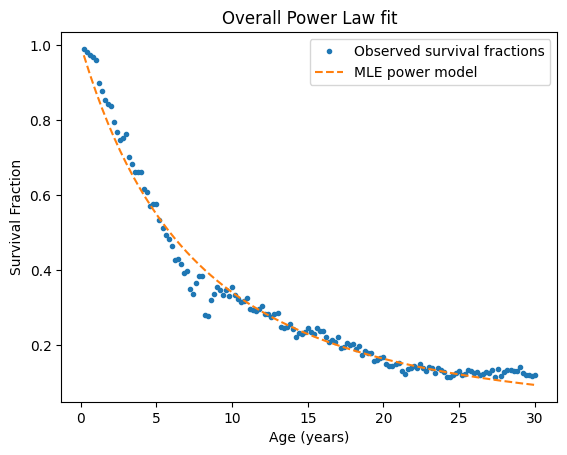

In [15]:
# Overall fit
sf, ages = obtain_survival_fractions(df_analysis)
totals, survivors = obtain_total_alive_count(df_analysis)
lam, alpha = fit_power_model_mle(ages, survivors, totals)

fitted_S = model_survival_curve_power(ages, lam, alpha)

print(-neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
plt.title(f'Overall Power Law fit')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.legend()
plt.show()

ll for G: -198944.67602002603
params lam, alpha are [0.15939620783918204, 0.06554741498683739]


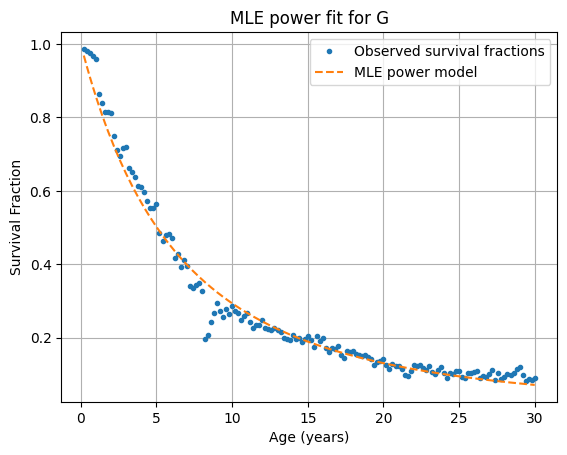

ll for M: -107109.28350819211
params lam, alpha are [0.11731541614021843, 0.034411625163760964]


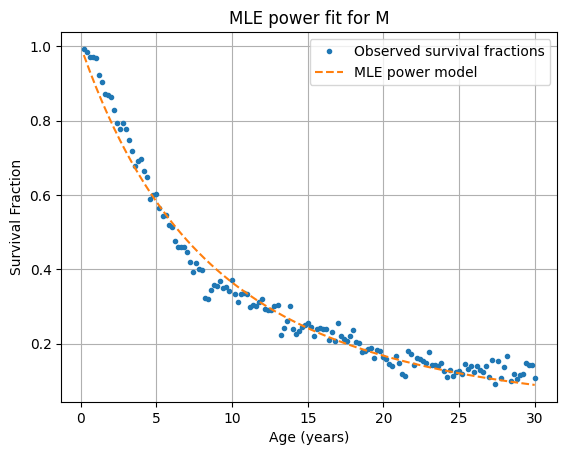

ll for F: -47789.798902493305
params lam, alpha are [0.08176472764699627, 0.003935370422210266]


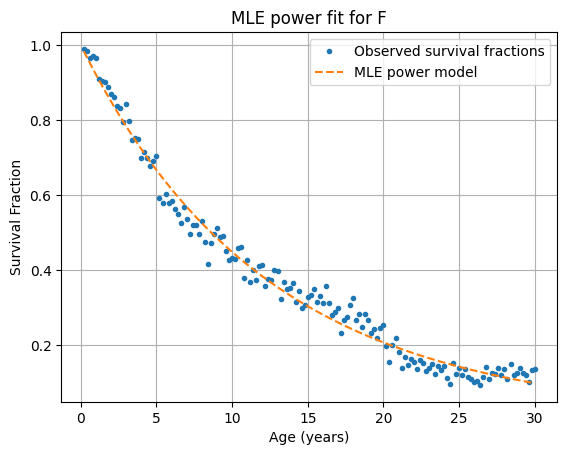

ll for J: -57151.028483457456
params lam, alpha are [0.14493123334359467, 0.05110383747571648]


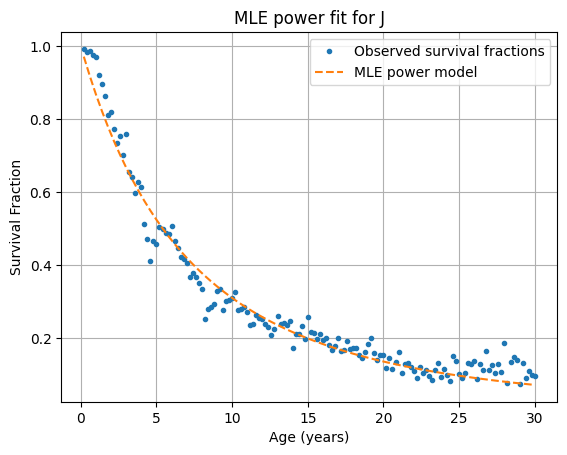

ll for K: -56413.996435860274
params lam, alpha are [0.07428516022902562, 0.0205752635062873]


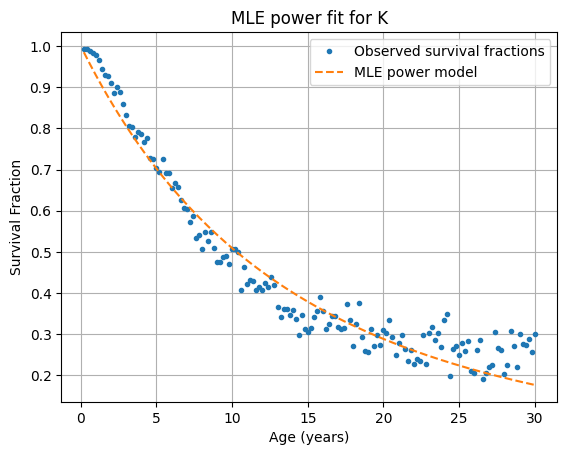

ll for C: -39594.276983044154
params lam, alpha are [0.11483004768371019, 0.06612013174973419]


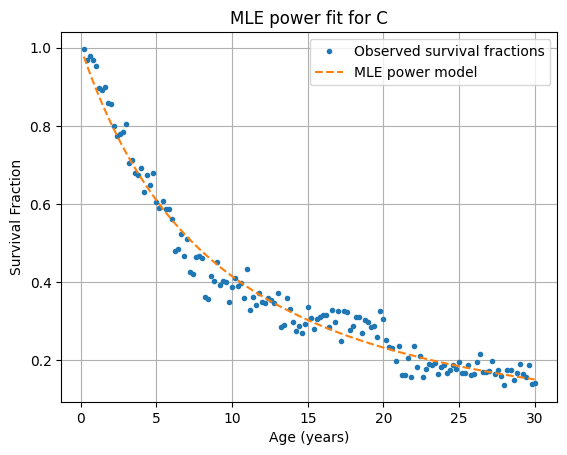

ll for H: -44001.194033550666
params lam, alpha are [0.2887388576800101, 0.29271178534385794]


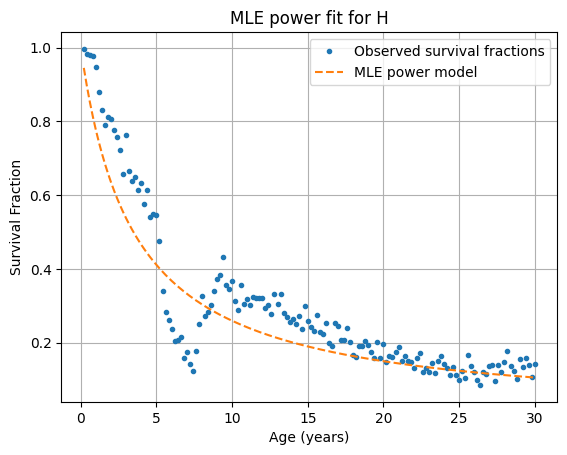

ll for S: -35960.84447700728
params lam, alpha are [0.18288352807518304, 0.11066509005322438]


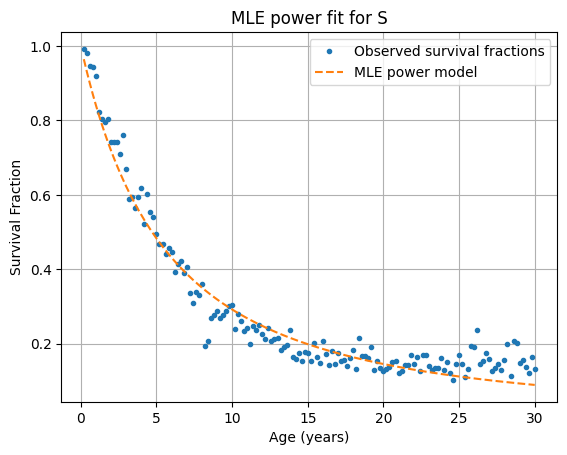

ll for N: -37101.62760374337
params lam, alpha are [0.14828700526875624, 0.06301550110710948]


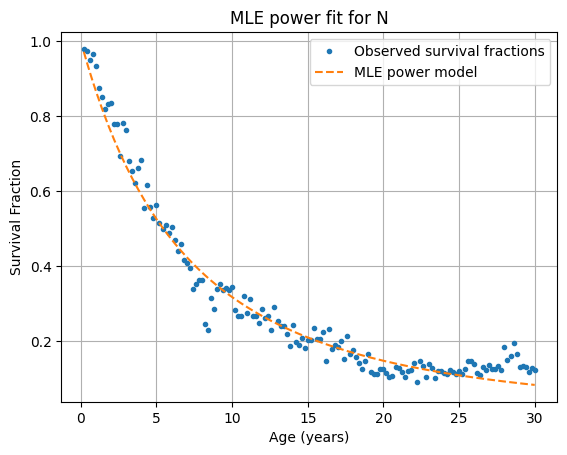

ll for I: -34289.22862246033
params lam, alpha are [0.13748459251913608, 0.02674362264816605]


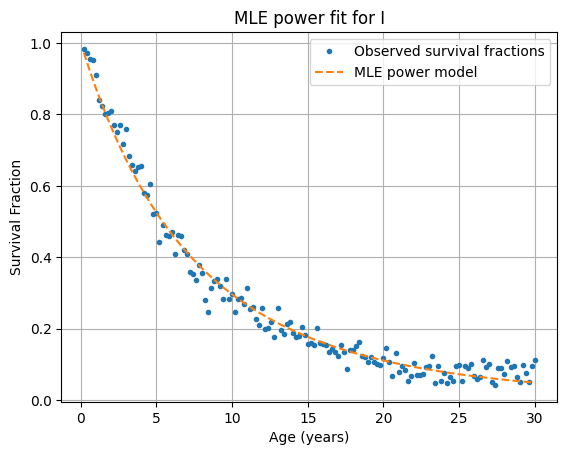

ll for P: -25212.25122378966
params lam, alpha are [0.1318053740138992, 0.03862506384367797]


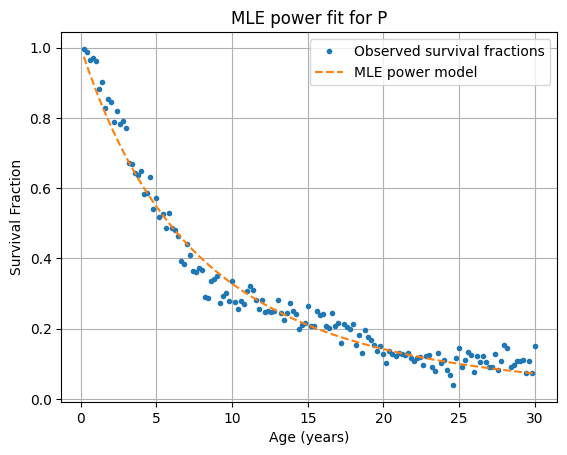

ll for L: -11928.88941323376
params lam, alpha are [0.07361776872843152, 0.0013499979796145912]


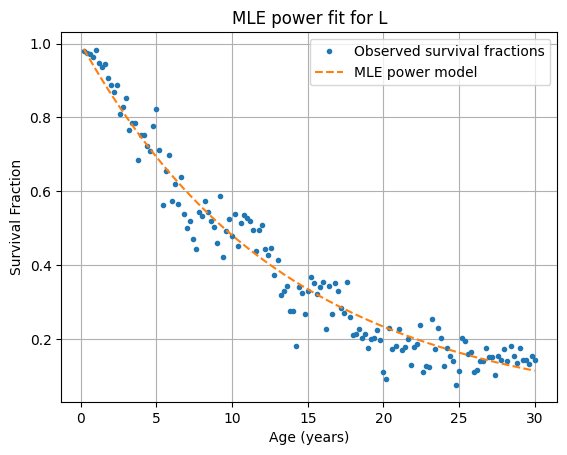

ll for Q: -12903.93185985435
params lam, alpha are [0.08504126133431111, 0.04439811016610487]


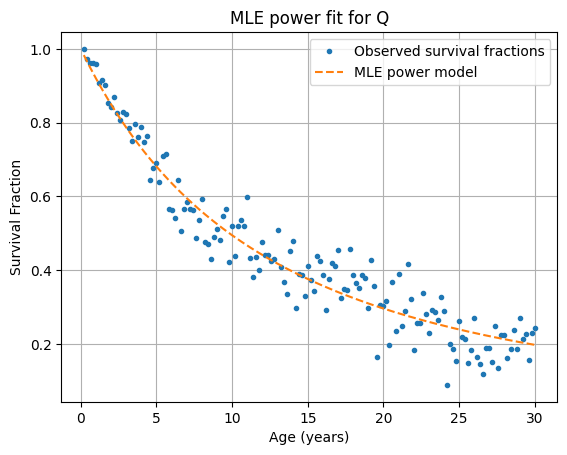

ll for R: -7533.920462008317
params lam, alpha are [0.13942475710811472, 0.029440721713113144]


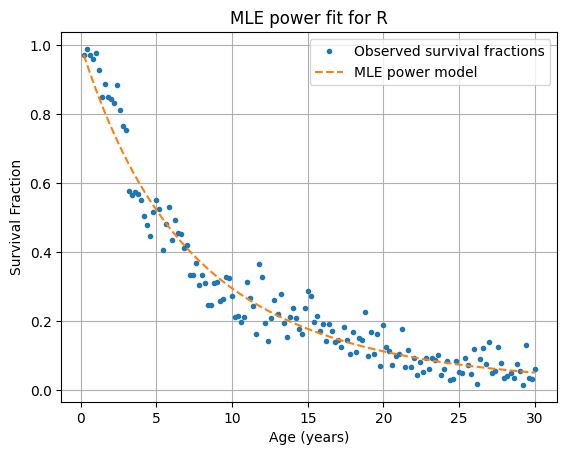

In [17]:
sector_ll_power = []

for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    sector_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
def compute_aic_bic(neg_logL, k, n):
    '''
    k = number of params
    n = number of observations
    '''

    aic = 2 * k + 2 * neg_logL
    bic = k * np.log(n) + 2 * neg_logL
    return aic, bic

In [76]:
from scipy.optimize import minimize_scalar

def model_survival_curve_constant(ages, mu):
    return np.exp(-mu * ages)

def neg_log_likelihood_constant(mu, ages, survivors, totals):
    if mu < 0:
        return np.inf
    S_vals = model_survival_curve_constant(ages, mu)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12) 
    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL

def fit_constant_model_mle(ages, survivors, totals):
    bounds = (1e-6, 0.5)
    result = minimize_scalar(neg_log_likelihood_constant, bounds=bounds, args=(ages, survivors, totals), method='bounded')
    return result

0.09988040907663956


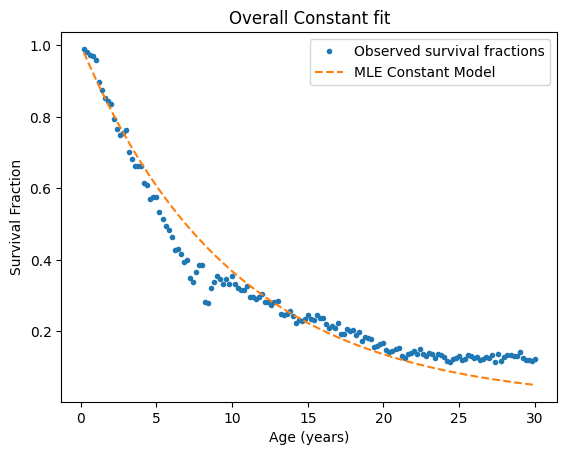

In [77]:
# Plot fit
sf, ages = obtain_survival_fractions(df_analysis)
totals, survivors = obtain_total_alive_count(df_analysis)
mu_const = fit_constant_model_mle(ages, survivors, totals).x
fitted_S = model_survival_curve_constant(ages, mu_const)
print(mu_const)

plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
plt.plot(ages, model_survival_curve_constant(ages, mu_const), label='MLE Constant Model', linestyle='--')
plt.title(f'Overall Constant fit')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.legend()
plt.show()

0.07273894972602155
-11929.049586597648
-23856.099173195296


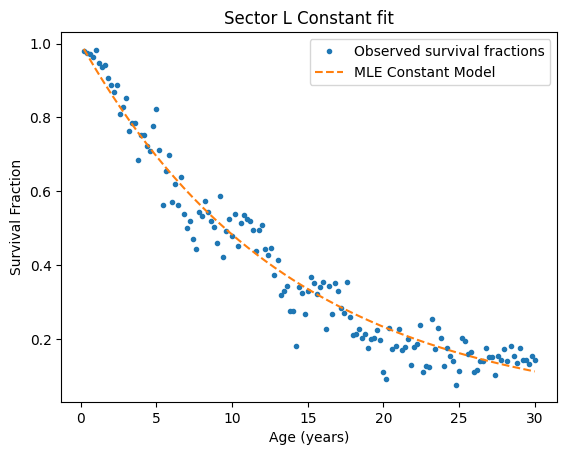

In [23]:
# Plot fit
sf, ages = obtain_survival_fractions(df_analysis, 'Sector', 'L')
totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', 'L')
mu_const = fit_constant_model_mle(ages, survivors, totals).x
fitted_S = model_survival_curve_constant(ages, mu_const)
print(mu_const)
# AIC
print(-neg_log_likelihood_constant(mu_const, ages, survivors, totals))
print(2*1 + 2 * -neg_log_likelihood_constant(mu_const, ages, survivors, totals))

plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
plt.plot(ages, model_survival_curve_constant(ages, mu_const), label='MLE Constant Model', linestyle='--')
plt.title(f'Sector L Constant fit')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.legend()
plt.show()

G: 0.11239679018019465


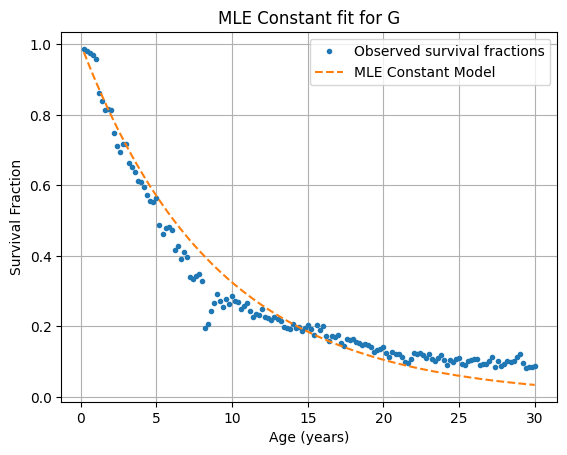

M: 0.09689351664224637


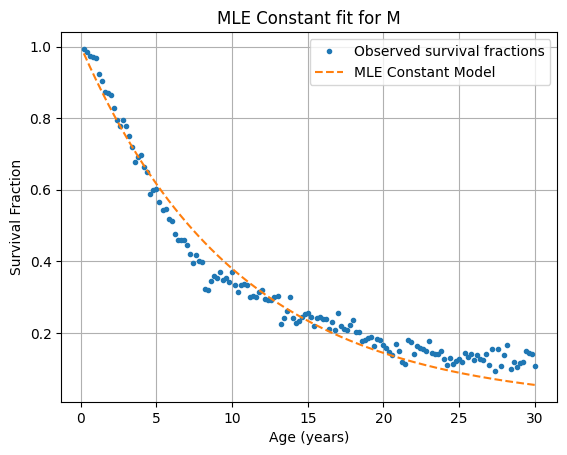

F: 0.0790919977081113


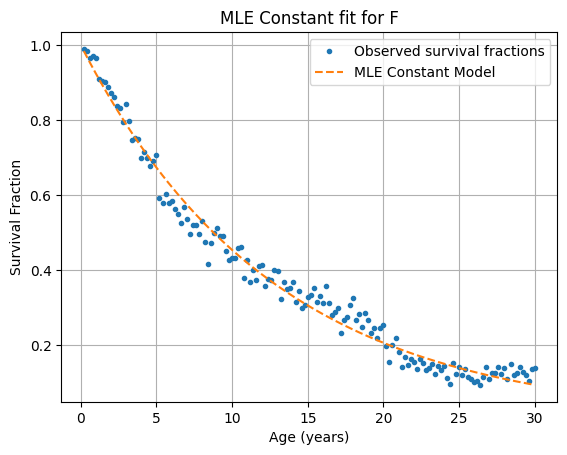

J: 0.11343934766500374


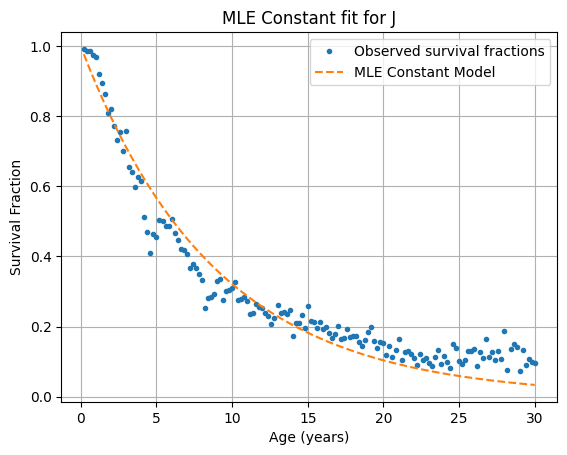

K: 0.0653900622135685


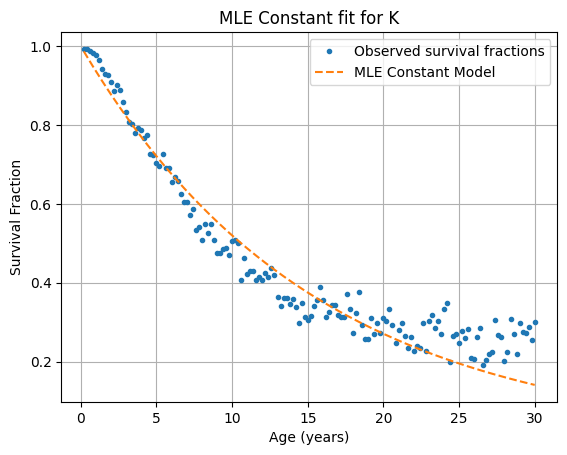

C: 0.07685346428347627


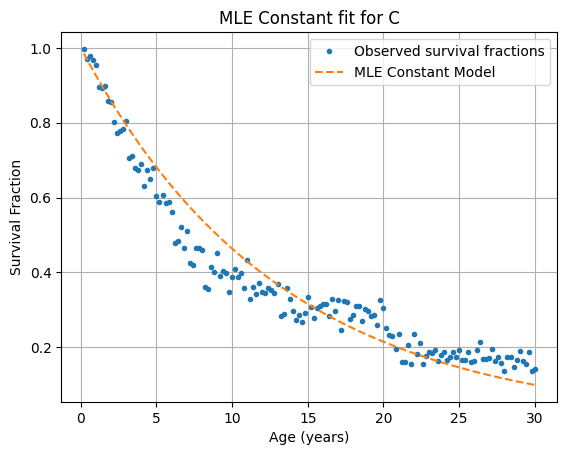

H: 0.1265232166726972


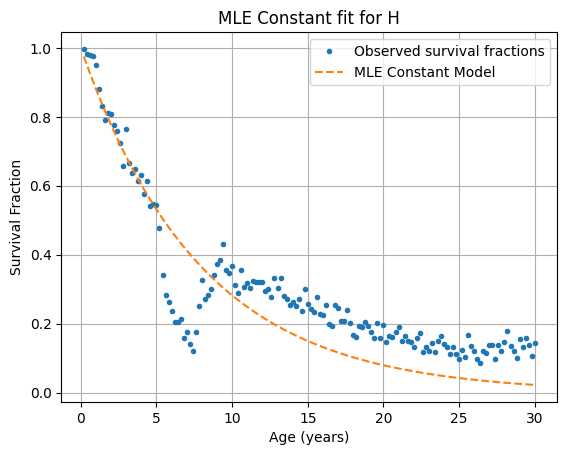

S: 0.11127928939362941


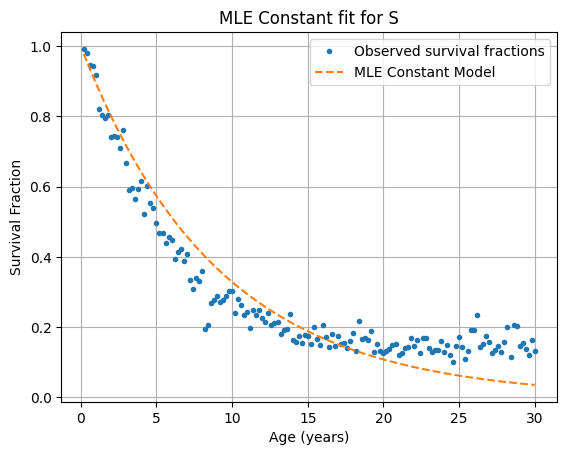

N: 0.1054891186419669


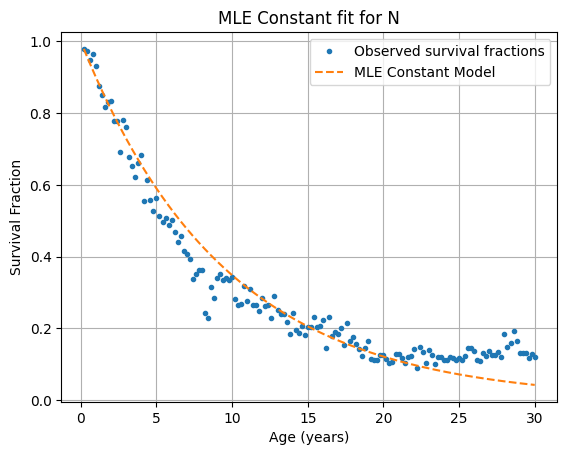

I: 0.11795239974341132


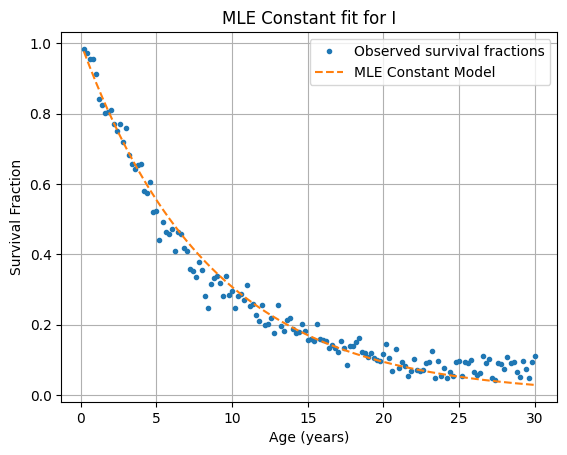

P: 0.10717147311870337


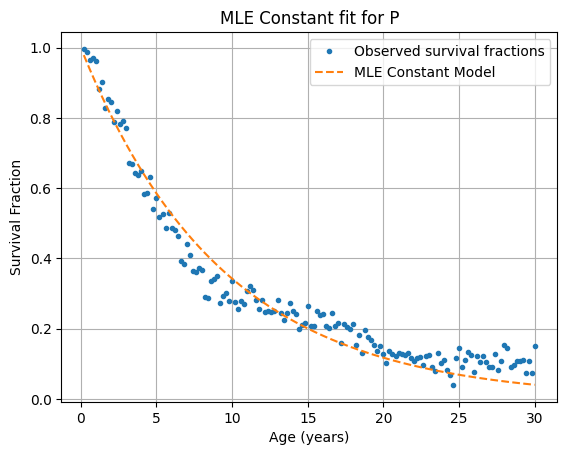

L: 0.07273894972602155


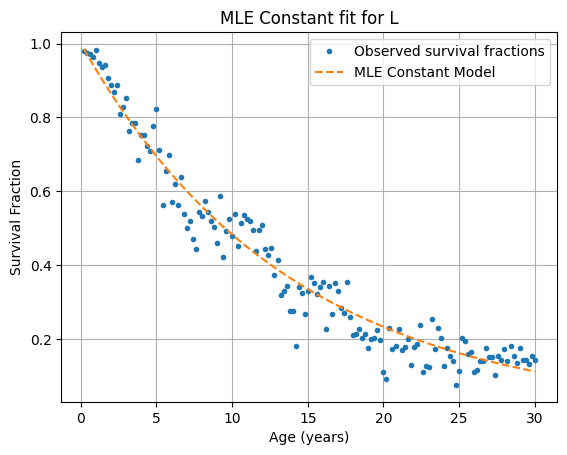

Q: 0.06599706566487386


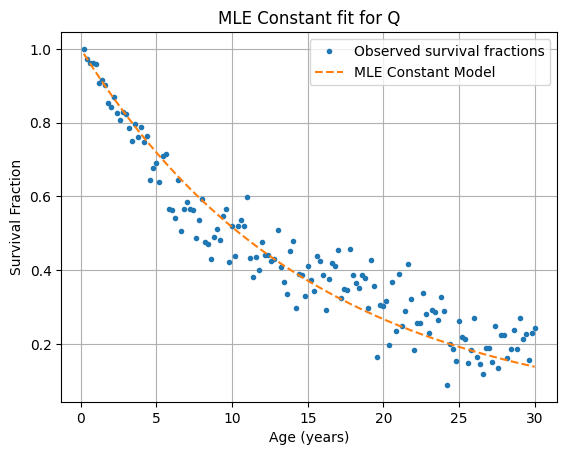

R: 0.1169891464416118


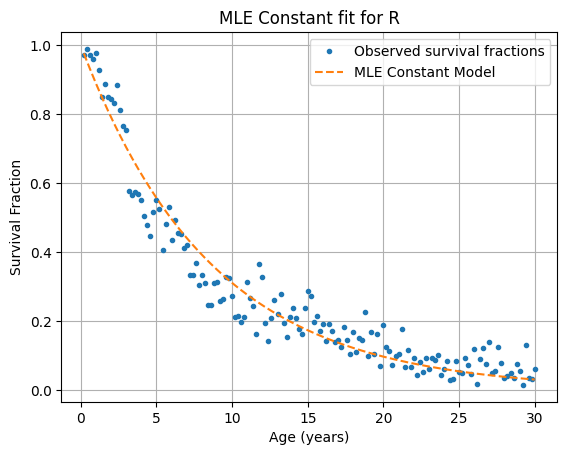

In [51]:
sector_ll_constant = []
for fil in sector_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)
    result = fit_constant_model_mle(ages, survivors, totals)
    print(f'{fil}: {result.x}')
    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, model_survival_curve_constant(ages, result.x), label='MLE Constant Model', linestyle='--')
    plt.title(f'MLE Constant fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()
    sector_ll_constant.append(result.fun)

sector_aic_constant, sector_bic_constant = compute_aic_bic(np.array(sector_ll_constant), 1, len(ages))

In [ ]:
sector_aic_hill, sector_bic_hill = compute_aic_bic(np.array(sector_ll_hill), 4, len(ages))
sector_aic_power, sector_bic_power = compute_aic_bic(np.array(sector_ll_power), 2, len(ages))

In [78]:
sector_df_aic = pd.DataFrame({
    'Sector': sector_list,
    'AIC_Constant': sector_aic_constant,
    'AIC_Power': sector_aic_power,
    'AIC_Hill': sector_aic_hill
})
sector_df_aic.head(14)

,Sector,AIC_Constant,AIC_Power,AIC_Hill
0,G,403003.558220,397893.352040,396597.301720
1,M,215073.436803,214222.567016,215938.704126
2,F,95591.231703,95583.597805,95571.327463
3,J,115198.947313,114306.056967,113961.264178
4,K,113024.116642,112831.992872,112433.754754
5,C,79977.750001,79192.553966,79079.075960
6,H,92921.022848,88006.388067,85957.700992
7,S,73435.100371,71925.688954,71512.573473
8,N,74976.410629,74207.255207,74032.644264
9,I,68789.867664,68582.457245,68503.126347


In [79]:
sector_df_bic = pd.DataFrame({
    'Sector': sector_list,
    'bic_Constant': sector_bic_constant,
    'bic_Power': sector_bic_power,
    'bic_Hill': sector_bic_hill
})
sector_df_bic.head(14)

,Sector,bic_Constant,bic_Power,bic_Hill
0,G,403006.568855,397899.373311,396609.344261
1,M,215076.447439,214228.588287,215950.746667
2,F,95594.242338,95589.619076,95583.370004
3,J,115201.957948,114312.078238,113973.306719
4,K,113027.127278,112838.014142,112445.797295
5,C,79980.760636,79198.575237,79091.118501
6,H,92924.033483,88012.409338,85969.743533
7,S,73438.111007,71931.710225,71524.616015
8,N,74979.421264,74213.276478,74044.686805
9,I,68792.878300,68588.478516,68515.168889


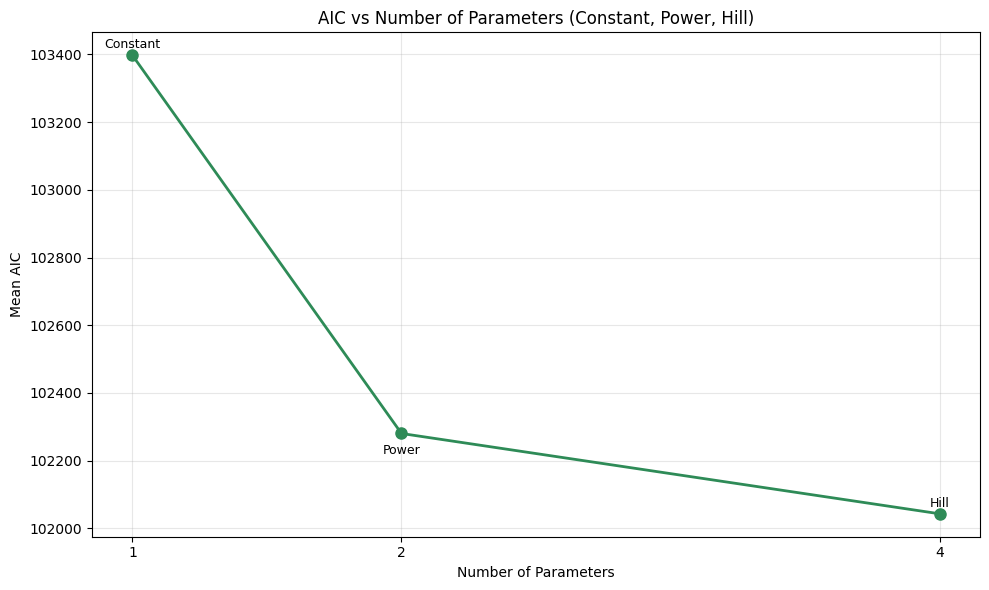

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the number of parameters for each model
model_params = {
    'AIC_Hill': 4,
    'AIC_Power': 2,
    'AIC_Constant': 1
}

# Calculate mean AIC values across all sectors for each model
mean_aic = {}
for col in ['AIC_Hill', 'AIC_Power', 'AIC_Constant']:
    mean_aic[col] = sector_df_aic[col].mean()

# Create comparison dataframe
comparison_data = []
for model, aic_val in mean_aic.items():
    comparison_data.append({
        'Model': model,
        'Parameters': model_params[model],
        'Mean_AIC': aic_val
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Parameters')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(comparison_df['Parameters'], comparison_df['Mean_AIC'], 'o-', linewidth=2, markersize=8, color='#2E8B57')
ax.set_xlabel('Number of Parameters')
ax.set_ylabel('AIC')
ax.set_title('AIC vs Number of Parameters (Constant, Power, Hill)')
ax.grid(True, alpha=0.3)
ax.set_xticks([1, 2, 4])

# Add model labels
for _, row in comparison_df.iterrows():
    model_name = row['Model'].replace('AIC_', '')
    if model_name == 'Power':
        ax.annotate(model_name,
                    (row['Parameters'], row['Mean_AIC']),
                    textcoords="offset points",
                    xytext=(0,-15),
                    ha='center', fontsize=9)
    else:
        ax.annotate(model_name,
                    (row['Parameters'], row['Mean_AIC']),
                    textcoords="offset points",
                    xytext=(0,5),
                    ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [80]:
sector_df_bic = pd.DataFrame({
    'Sector': sector_list,
    'BIC_Hill': sector_bic_hill,
    'BIC_Power': sector_bic_power,
    'BIC_Constant': sector_bic_constant
})
sector_df_bic.head(14)

,Sector,BIC_Hill,BIC_Power,BIC_Constant
0,G,396609.344261,397899.373311,403006.568855
1,M,215950.746667,214228.588287,215076.447439
2,F,95583.370004,95589.619076,95594.242338
3,J,113973.306719,114312.078238,115201.957948
4,K,112445.797295,112838.014142,113027.127278
5,C,79091.118501,79198.575237,79980.760636
6,H,85969.743533,88012.409338,92924.033483
7,S,71524.616015,71931.710225,73438.111007
8,N,74044.686805,74213.276478,74979.421264
9,I,68515.168889,68588.478516,68792.878300


In [81]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

df_params.head(14)

,mu_ub,mu_lb,K,m
G,0.137728,6.040066e-02,9.678611,38.286534
M,0.108534,6.040545e-02,10.324137,20.272106
F,0.082849,7.532165e-02,7.246080,99.999927
J,0.131389,6.387241e-02,9.026894,64.590033
K,0.070120,1.106818e-02,17.600966,11.716329
C,0.099976,4.926992e-02,8.699287,100.000000
H,0.190144,2.801594e-02,6.937679,100.000000
S,0.140572,1.000000e-10,12.954250,5.199153
N,0.123962,1.000000e-10,16.432802,3.676398
I,0.126396,1.000000e-10,20.851484,3.869442


In [83]:
parameters

[[0.13772780796801345,
  0.06040065635354765,
  9.678611031814139,
  38.28653412450151],
 [0.10853412588782649,
  0.060405453614713986,
  10.324137068120953,
  20.272105749873536],
 [0.08284945935354733,
  0.07532165486572806,
  7.246079688090822,
  99.99992722770091],
 [0.13138896943819373,
  0.06387240987874851,
  9.026894200245238,
  64.59003275843841],
 [0.07012013735407156,
  0.011068176577001085,
  17.600965883019793,
  11.716328585887581],
 [0.09997560159043367, 0.049269924679968866, 8.699286997697827, 100.0],
 [0.19014381450690954, 0.028015942761638372, 6.937678823494837, 100.0],
 [0.14057226596633066, 1e-10, 12.954249620403116, 5.199152676121435],
 [0.12396183075343398, 1e-10, 16.432802053332697, 3.6763982546287552],
 [0.12639621277376695,
  1.0000001467199392e-10,
  20.851484353072767,
  3.8694421065642923],
 [0.12121307544489934, 0.06868412785046317, 9.445279125853938, 100.0],
 [0.07256783090508868,
  0.0725678283579821,
  14.249169553345428,
  0.8209674189944658],
 [0.07830

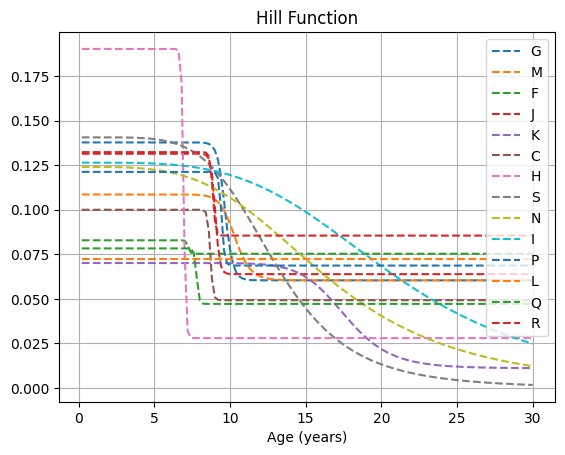

In [82]:
for param in parameters:

    plt.plot(ages, hill_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

plt.title(f'Hill Function')
plt.xlabel('Age (years)')
plt.legend()
plt.grid(True)
plt.show()

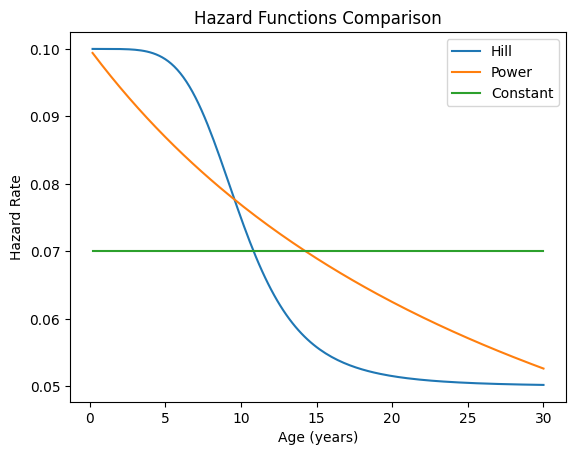

In [42]:
# Compare hazard functions
def power_hazard(a, lam, alpha):
    return lam / (1 + alpha * a)
def constant_hazard(a, mu):
    return mu * np.ones_like(a)

plt.plot(ages, hill_hazard(ages, 0.1, 0.05, 10, 5), label = 'Hill')
plt.plot(ages, power_hazard(ages, 0.1, 0.03), label = 'Power')
plt.plot(ages, constant_hazard(ages, 0.07), label = 'Constant')
plt.title('Hazard Functions Comparison')
plt.xlabel('Age (years)')
plt.ylabel('Hazard Rate')
plt.legend()
plt.show()

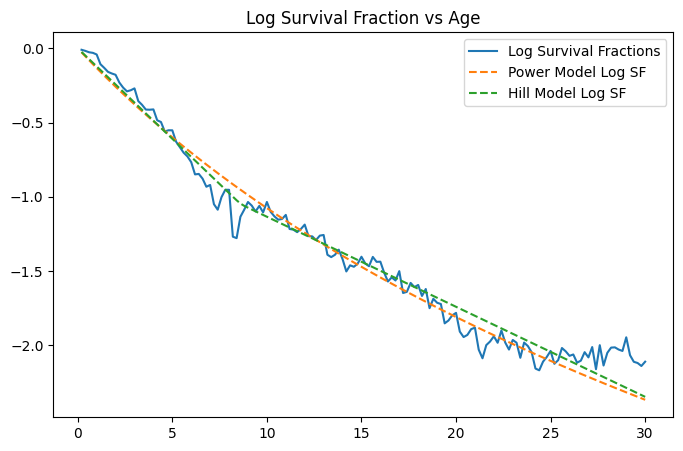

In [43]:
# Plotting log-survival fractions against age overall
survival_fractions, ages = obtain_survival_fractions(df_analysis)
totals, survivors = obtain_total_alive_count(df_analysis)
plt.figure(figsize=(8, 5))
plt.plot(ages, np.log(survival_fractions), label='Log Survival Fractions')

lam, alpha = fit_power_model_mle(ages, survivors, totals)
fitted_S_power = model_survival_curve_power(ages, lam, alpha)
plt.plot(ages, np.log(fitted_S_power), label='Power Model Log SF', linestyle='--')

mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals, [0.13, 0.00001, 10.0, 3.0]).x
fitted_S_hill = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
plt.plot(ages, np.log(fitted_S_hill), label='Hill Model Log SF', linestyle='--')


plt.legend()
plt.title("Log Survival Fraction vs Age")
plt.show()